In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime as dt
plt.style.use("fivethirtyeight")


df = pd.read_csv("BTC-USD_2016.csv")
num_pre_days = 120
num_output_days = 7

In [2]:
data = df.filter(["Close"])
dataset = data.values
print(dataset)
training_data_len = math.ceil(len(dataset) * 0.8)
print(training_data_len)

[[  800.875977]
 [  834.281006]
 [  864.539978]
 ...
 [16717.173828]
 [16552.572266]
 [16613.134766]]
1761


In [3]:
#Scale Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data.shape

(2201, 1)

In [4]:
#Create training dataset
#scaled first
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(num_pre_days, len(train_data)):
    x_train.append(train_data[i-num_pre_days:i, 0])
    y_train.append(scaled_data[i:i+num_output_days, 0])

In [5]:
#Convert x_train and y_train to np
x_train, y_train = np.array(x_train), np.array(y_train)
print(y_train)
#Reshape data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #num of samples, time, feature
x_train.shape

[[0.0064761  0.00675744 0.00665218 ... 0.00642999 0.00707291 0.00730259]
 [0.00675744 0.00665218 0.00679681 ... 0.00707291 0.00730259 0.00753601]
 [0.00665218 0.00679681 0.00642999 ... 0.00730259 0.00753601 0.00808475]
 ...
 [0.8477935  0.84660208 0.91057101 ... 0.90996714 0.91704107 0.95051831]
 [0.84660208 0.91057101 0.90006376 ... 0.91704107 0.95051831 0.97643339]
 [0.91057101 0.90006376 0.90996714 ... 0.95051831 0.97643339 0.91979741]]


(1641, 120, 1)

In [6]:
#Build LSTM MODEL
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(num_output_days))

2023-01-23 16:06:40.651701: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
#Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [8]:
#Train model
model.fit(x_train, y_train, batch_size=5, epochs=3)

Epoch 1/3
329/329 [==============================] - 21s 54ms/step - loss: 0.0044
Epoch 2/3
329/329 [==============================] - 17s 52ms/step - loss: 0.0019
Epoch 3/3
329/329 [==============================] - 17s 52ms/step - loss: 0.0014


In [9]:
#Create the testing dataset
#New array containing scaled values from index 1542 to 2002
test_data = scaled_data[training_data_len-num_pre_days:, :]
#Create x_test, y_test
x_test =[]
y_test = dataset[training_data_len:,:]
for i in range(num_pre_days, len(test_data)):
    x_test.append(test_data[i-num_pre_days:i, 0])
    

In [10]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [11]:
#get models predicted price value
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
print(predictions)

14/14 [==============================] - 1s 22ms/step
[[55996.79  55454.438 56059.062 ... 53408.574 53729.453 50855.59 ]
 [56284.082 55781.85  56441.727 ... 53606.82  54048.477 50981.707]
 [56758.74  56293.184 56966.46  ... 53973.258 54540.215 51225.977]
 ...
 [17492.668 17854.854 17947.395 ... 17652.314 17587.863 16787.23 ]
 [17501.77  17867.914 17951.434 ... 17665.521 17594.43  16792.201]
 [17495.89  17864.299 17941.67  ... 17666.047 17585.805 16790.33 ]]


In [12]:
#plot
out_predict = []
last_index = 0
print(len(predictions))
for i in range(0, len(predictions), num_output_days):
    for j in predictions[i]:
        out_predict.append(j)
    last_index = i

print(last_index)

        
train = data[:training_data_len]
valid = data[training_data_len:]
out_predict = out_predict[:valid.shape[0]]
print(len(out_predict))
print(valid.shape)

440
434
440
(440, 1)


In [13]:
valid["Predictions"] = out_predict
# plt.figure(figsize=(16, 8))
# plt.title("Model")
# plt.xlabel("Days")
# plt.ylabel("Price")
# plt.plot(data["Close"])
# plt.plot(valid["Close"], color = "red")
# plt.plot(valid["Predictions"], alpha = 0.8, color = "orange")
# plt.legend(["Train", "Val", "Predictions"], loc = "lower right")
print(valid)
print(data.head())
# plt.show()

             Close   Predictions
1761  60892.179688  55996.789062
1762  61553.617188  55454.437500
1763  62026.078125  56059.062500
1764  64261.992188  53012.285156
1765  65992.835938  53408.574219
...            ...           ...
2196  16841.986328  17880.197266
2197  16919.804688  17994.576172
2198  16717.173828  17260.642578
2199  16552.572266  17688.679688
2200  16613.134766  17625.619141

[440 rows x 2 columns]
        Close
0  800.875977
1  834.281006
2  864.539978
3  921.984009
4  898.822021


/var/folders/z6/pm4tg_q52fg5zjct74hgnbyr0000gn/T/ipykernel_25343/573357586.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["Predictions"] = out_predict


1/1 [==============================] - 0s 25ms/step
[[17484.84  17854.652 17927.625 17200.918 17661.02  17572.752 16785.242]]
        pred_price
2201  17484.839844
2202  17854.652344
2203  17927.625000
2204  17200.917969
2205  17661.019531
2206  17572.751953
2207  16785.242188


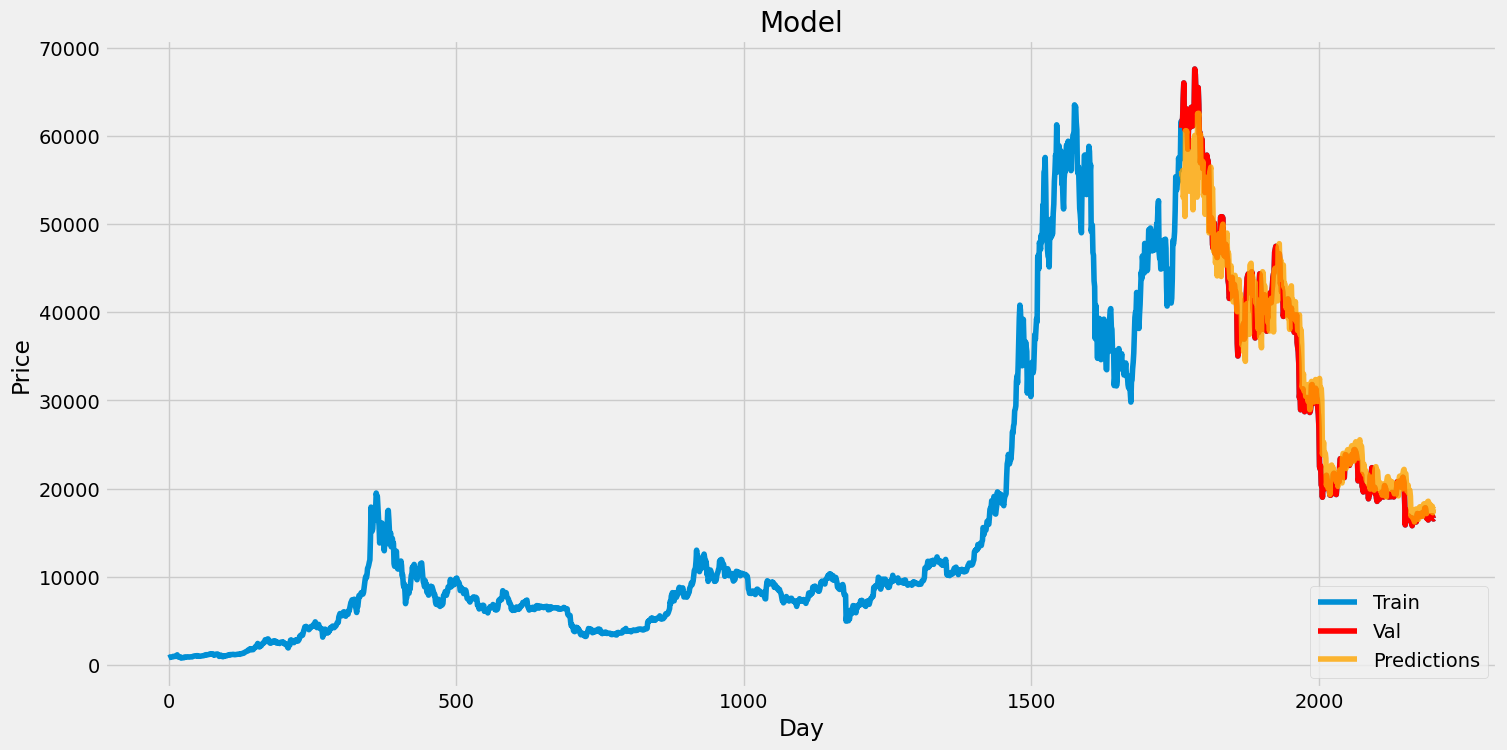

In [14]:
#Prediction Part
new_df = df.filter(["Close"])
last_pre_days = new_df[-num_pre_days:].values
last_pre_days = scaler.transform(last_pre_days)
X_test = []
X_test.append(last_pre_days)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
pred_future = model.predict(X_test)
pred_future = scaler.inverse_transform(pred_future)
print(pred_future)
pred_price = pd.DataFrame({"pred_price":pred_future[0]})
pred_price.set_index(pd.Index([ i for i in range(2201, 2201+num_output_days)]), inplace = True)
print(pred_price)
plt.figure(figsize=(16, 8))
plt.title("Model")
plt.xlabel("Day")
plt.ylabel("Price")
plt.plot(data["Close"])
plt.plot(valid["Close"], color = "red")
plt.plot(valid["Predictions"], alpha = 0.8, color = "orange")
#plt.plot(pred_price["pred_price"], color = "green")
plt.legend(["Train", "Val", "Predictions"], loc = "lower right")
plt.show()

15787.28418


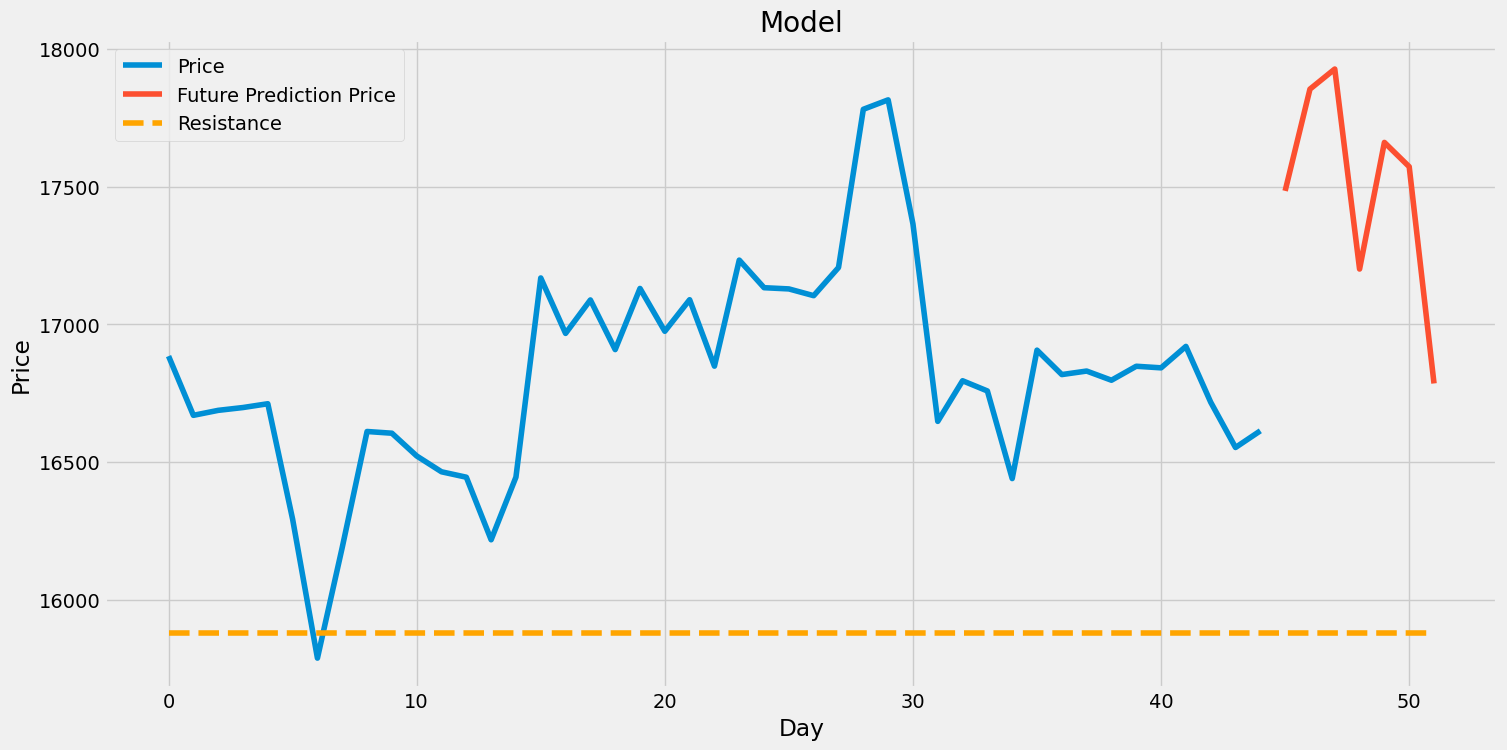

      pred_price
45  17484.839844
46  17854.652344
47  17927.625000
48  17200.917969
49  17661.019531
50  17572.751953
51  16785.242188


In [15]:
rececent_data = data.iloc[-45:]
rececent_data.reset_index(inplace=True, drop=True)
print(rececent_data["Close"].min())
plt.figure(figsize=(16, 8))
plt.plot(rececent_data["Close"])
pred_price.set_index(pd.Index([ i for i in range(45, 45+num_output_days)]), inplace = True)
plt.plot(pred_price["pred_price"])
plt.plot([15880 for _ in range(45+num_output_days)], color = "orange", linestyle = "--")
plt.title("Model")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend(["Price", "Future Prediction Price", "Resistance"])
plt.show()
print(pred_price)